# Baseline models

## Imports

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

from fastai.metrics import error_rate, auc_roc_score

import sys
sys.path.append("../scripts/")
from ppmi import *

import fastai.vision as fv

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import fastai
import imageio as io
import pandas as pd

## Loading and preparing the images

In [14]:
all_imgs_dir = Path("/home/eager/modeling-parkinsons/"
                    "data/png/mri_flattened_center_original/all_sizes")
all_imgs_paths = list(Path("/home/eager/modeling-parkinsons/"
                "data/png/mri_flattened_center_original/all_sizes").glob("*.png"))
metadf = pd.read_csv("/home/eager/data/PPMI/all_mri_t2_axial_metadata.csv").rename(columns=PPMI_META_RENAME_DICT)

In [15]:
metadf

,iid,pid,group,sex,age,visit,modality,desc,type,acq_date,fmt,downloaded
0,440704,91097,Prodromal,M,67,1,MRI,AX T2 FLAIR,Original,7/23/2014,DCM,NaN
1,440701,90456,Prodromal,M,83,1,MRI,t2 weighted double echo,Original,9/11/2013,DCM,NaN
2,951924,85242,Prodromal,M,66,7,MRI,AXIAL PD-T2 TSE FS,Original,2/08/2017,DCM,NaN
3,482358,85242,Prodromal,M,64,1,MRI,AXIAL PD-T2 TSE FS,Original,2/18/2015,DCM,NaN
4,643421,85242,Prodromal,M,65,5,MRI,AXIAL PD-T2 TSE FS,Original,2/03/2016,DCM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2699,440668,12593,Prodromal,F,67,1,MRI,*AX FSE T2,Original,2/24/2014,DCM,NaN
2700,814546,12224,Prodromal,F,66,1,MRI,T2,Original,10/28/2013,DCM,NaN
2701,814547,12224,Prodromal,F,66,1,MRI,FLAIR,Original,10/28/2013,DCM,NaN
2702,450999,10874,Prodromal,F,73,1,MRI,Ax T2 FLAIR,Original,9/05/2014,DCM,NaN


In [16]:
fnames = []
labels = []

for p in all_imgs_paths:
    pid, iid = get_pid_iid_from_fname(p.name)
    group = get_img_info_from_iid(metadf, iid)["group"]
    
    if group not in ["Control", "PD"]:
        continue
    
    label = group
    labels.append(label)
    
    fnames.append(p)

In [17]:
np.random.seed(2)

In [18]:
data = fv.ImageDataBunch.from_lists(
    all_imgs_dir,
    fnames,
    labels,
    ds_tfms=fv.get_transforms(), size=200, bs=16).normalize()

In [19]:
data.classes

['Control', 'PD']

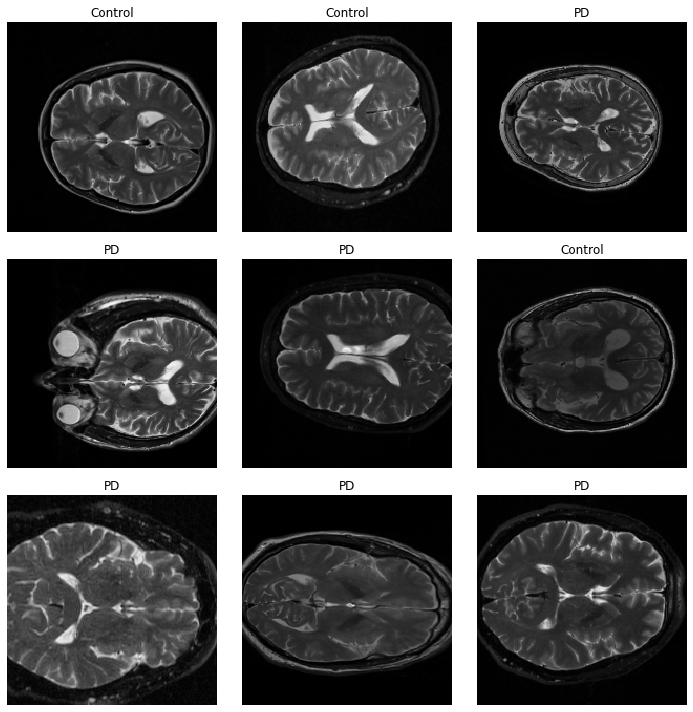

In [20]:
data.show_batch(rows=3, figsize=(10, 10))

In [10]:
print(torch.__version__)

model = nn.Sequential(
    nn.Conv2d(3, 20, 15),
    nn.Conv2d(20, 20, 15),
    nn.Conv2d(20, 20, 7),
    nn.Conv2d(20, 10, 3),
    nn.Flatten(),
    nn.Linear(268960, 128),
    nn.Linear(128, 2)
)

learn = fv.Learner(data, model, metrics=[error_rate])

1.2.0


In [21]:
learn = fv.cnn_learner(data, fv.models.vgg16_bn, metrics=[error_rate, fv.AUROC()])
learn.crit = nn.CrossEntropyLoss(weight=torch.Tensor([0.37, 1]))
learn.fit_one_cycle(6, 5e-3)

epoch,train_loss,valid_loss,error_rate,auroc,time
0,1.181851,0.902153,0.315789,0.543060,00:09
1,1.090123,0.943471,0.378947,0.603540,00:07
2,0.880392,0.749290,0.347368,0.662207,00:07
3,0.778462,0.624144,0.321053,0.675864,00:07
4,0.682196,0.567752,0.284211,0.697185,00:07
5,0.582969,0.586843,0.305263,0.686873,00:07


## Interpreting Results

In [23]:
interp = fv.ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()

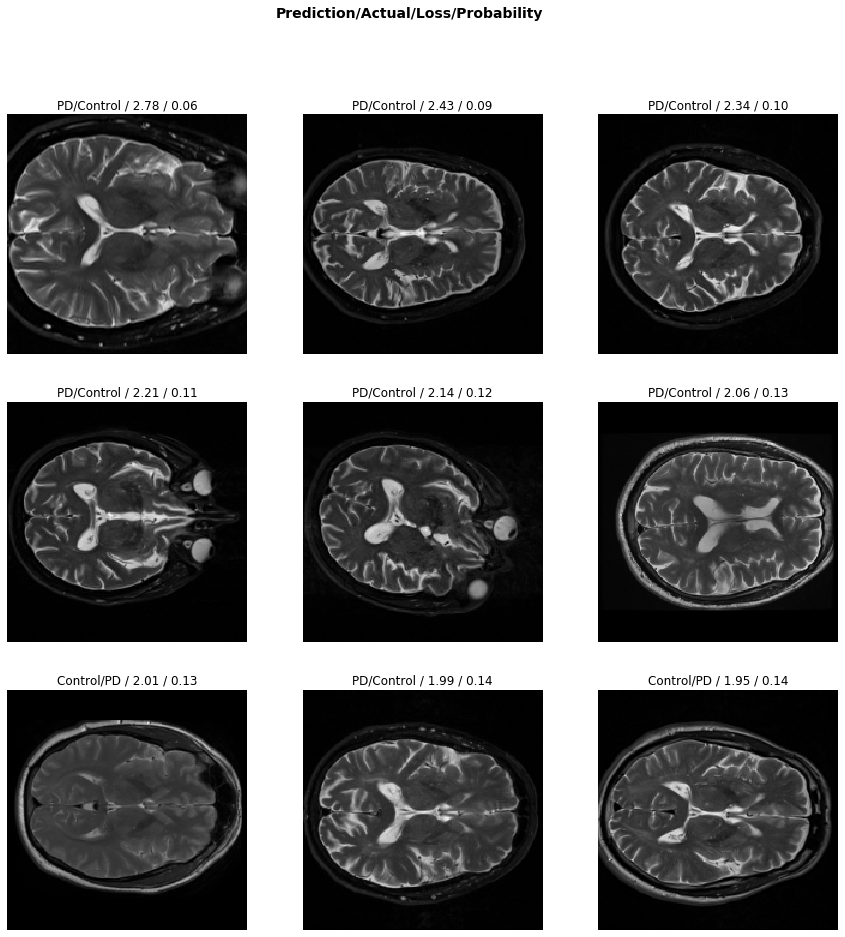

In [24]:
interp.plot_top_losses(9, figsize=(15, 15))

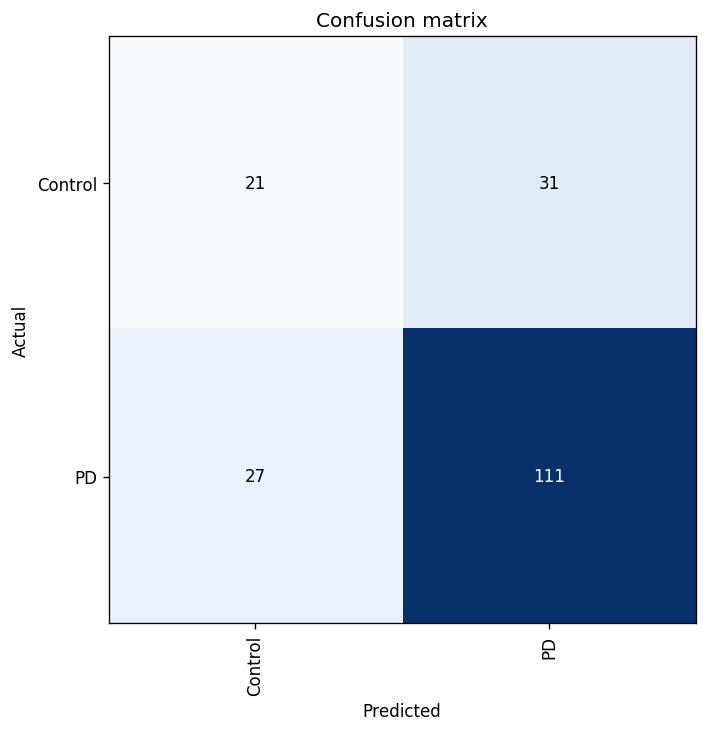

In [25]:
interp.plot_confusion_matrix(figsize=(6, 6), dpi=120)

In [ ]:

learn.save("vgg16-mri-{}", return_path=True)